## Overview of Python Functions for Star Imaging and Transit Modelling

This code defines several Python functions aimed at simulating and processing star images and transit models.

### Function: `save_image_to_fits`

**Purpose**: Saves 2D image data to a FITS (Flexible Image Transport System) file, commonly used in astronomy.

---

### Function: `generate_transit_model_2D`

**Purpose**: Generates a 2D transit model over a sequence of images for multiple transits. It uses the `RoadRunnerModel` for simulating transits with some random variability in the parameters. It returns a 2D NumPy array containing the generated transit models for different periods.

---

### Function: `generate_transit_model`

**Purpose**: Similar to `generate_transit_model_2D`, but for a single transit model.

---

### Function: `generate_fixed_stars`

**Purpose**: Simulates fixed stars in a 2D image. Star positions and brightness are parameters. It applies random fluctuations to the brightness and modifies the brightness for the brightest five stars based on transit models. The function also uses the `Moffat2D` model to simulate the star shapes. Noise is added to the image, and negative values are clipped.

---

### Function: `display_image`

**Purpose**: Displays a 2D image using Matplotlib with grayscale color mapping.

---

In these functions, the following libraries are mainly used:

- **NumPy**: for numerical operations, particularly on arrays.
- **Astropy**: for handling FITS files (`fits`), data tables (`Table`), and 2D Moffat profiles (`Moffat2D`).
- **Matplotlib**: for image visualization.
- **pytransit's RoadRunnerModel**: for generating realistic transit models.

These functions collectively form a toolset that could be useful for simulating and analyzing celestial bodies and their transits in 2D images.


In [7]:
%pylab inline
rc('figure', figsize=(13,5))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [8]:
from pytransit import RoadRunnerModel

In [9]:
import numpy as np
from astropy.modeling.functional_models import Moffat2D
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.table import Table
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
from astropy.io import fits
from datetime import datetime, timedelta
#from pytransit import RoadRunnerModel
from astropy.modeling.functional_models import Moffat2D
import os

import matplotlib.pyplot as plt
from tqdm import tqdm 


def save_image_to_fits(image_data, filename, obs_time):
    hdu = fits.PrimaryHDU(image_data)
    hdr = hdu.header
    hdr['DATE-OBS'] = obs_time.strftime('%Y-%m-%dT%H:%M:%S')
    hdu.writeto(filename, overwrite=True)
    
def generate_transit_model_2D(num_images, num_transits):
    # Initialize an empty list to store all transit models
    transits = []
    
    for i in range(num_transits):
        time = np.linspace(-0.05, 0.05, num_images)
        tm = RoadRunnerModel('nonlinear')
        tm.set_data(time)
        
        # Introduce some random variability in k and a
        k_var = 0.1 + np.random.normal(0, 0.01)  # Mean of 0.1, std dev of 0.01
        a_var = 4.2 + np.random.normal(0, 0.1)  # Mean of 4.2, std dev of 0.1

        # Generate the transit with a slightly different period for each one
        flux = tm.evaluate(k=k_var, ldc=[0.36, 0.04, 0.1, 0.05], t0=0.0, p=1.0, a=a_var, i=0.5*np.pi, e=0.0, w=0.0)
        transits.append(flux)

    # Convert the list of arrays into a 2D numpy array
    transits = np.array(transits)

    return transits    
 


 # Assuming RoadRunnerModel is from transit library

 # Assuming RoadRunnerModel is from transit library

def generate_transit_model(num_images):
    # Find factors of num_images between 3 and 6
    possible_dips = [i for i in range(2, 8) if num_images % i == 0]
    
    if not possible_dips:
        raise ValueError("num_images must have a factor between 3 and 6 to maintain uniformity in dips.")
    
    num_dips = np.random.choice(possible_dips)  # Random number of dips, chosen from factors of num_images
    
    # Define other parameters for the transit model
    period = np.random.uniform(0.5, 3.0)  # Random orbital period
    depth = np.random.uniform(0.1, 0.5)  # Random depth
    t0 = np.random.uniform(-0.01, 0.01)  # Random zero epoch
    a = np.random.uniform(3.5, 5.5)  # Random scaled semi-major axis
    i = np.random.uniform(0.48 * np.pi, 0.5 * np.pi)  # Random orbital inclination
    e = np.random.uniform(0.0, 0.25)  # Random eccentricity
    w = np.random.uniform(0.0, 2 * np.pi)  # Random argument of periastron
    ldc = np.random.uniform(0.0, 0.2, size=(1, 4))  # Random limb darkening coefficients
    
    # Create a time array centered around zero
    time = np.linspace(-period / 2, period / 2, num_images // num_dips)
    
    # Initialize the RoadRunnerModel with the nonlinear limb darkening model
    tm = RoadRunnerModel('nonlinear')
    tm.set_data(time)
    
    # Evaluate the transit model with the specified parameters for the first dip
    flux = tm.evaluate(k=depth, ldc=ldc, t0=t0, p=period, a=a, i=i, e=e, w=w)
    
    # Replicate the dip to create a model with multiple identical dips
    flux = np.tile(flux, num_dips)
    
    return flux


#def generate_transit_model(num_images):
#    time = np.linspace(-0.05, 0.05, num_images) 
#    tm = RoadRunnerModel('nonlinear')
#    tm.set_data(time)
#    flux = tm.evaluate(k=0.3, ldc=[0.36, 0.04, 0.1, 0.05], t0=0.0, p=1.0, a=4.2, i=0.5*np.pi, e=0.0, w=0.0)
#    return flux



# ...

def generate_fixed_stars(image_size, star_positions, fixed_brightness_values, gammas, alphas, fluxs, state, add_noise, transit_indices):
    params = dict([
        ('x_0', star_positions[:, 0]),
        ('y_0', star_positions[:, 1]),
        ('gamma', gammas),
        ('alpha', alphas)
    ])

    sources = Table()
    for name in params:
        sources[name] = params[name]
    
    sources['amplitude'] = fixed_brightness_values
    
    for idx in transit_indices:
        original_amplitude = sources['amplitude'][idx]
        sources['amplitude'][idx] *= fluxs[state]
    
    sources['x_0'] = np.round(sources['x_0']).astype(int)
    sources['y_0'] = np.round(sources['y_0']).astype(int)

    star_im = np.zeros(image_size)
    for source in sources:
        amplitude = source['amplitude']
        x_0 = source['x_0']
        y_0 = source['y_0']
        gamma = source['gamma']
        alpha = source['alpha']

        if add_noise == 'yes':
            gamma += np.random.normal(0, 0.1)  # Adding noise to gamma
            alpha += np.random.normal(0, 0.05)  # Adding noise to alpha

        star_model = Moffat2D(amplitude=amplitude, x_0=x_0, y_0=y_0, gamma=gamma, alpha=alpha)
        star = star_model(*np.indices(image_size))
        star_im += star

    if add_noise == 'yes':
        noise = np.random.normal(scale=200, size=image_size)
        star_im += noise

    star_im = np.clip(star_im, 0, None)
    return star_im


# ...


def display_image(image_data):
    plt.figure(figsize=(8, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')
    plt.title("Final Image")
    plt.show()
    
def plot_lc(time, flux, c=None, ylim=(0.8, 1.0025), ax=None):
    if ax is None:
        fig, ax = subplots()
    else:
        fig, ax = None, ax
    ax.plot(time, flux, c=c)
    ax.autoscale(axis='x', tight=True)
    setp(ax, xlabel='Time [d]', ylabel='Flux', xlim=time[[0,-1]], ylim=ylim)
    
    if fig is not None:
        fig.tight_layout()
    return ax

## Overview of Python Code for Analyzing Star Images from FITS Files

This code snippet is designed to open a FITS (Flexible Image Transport System) file containing star image data, identify star locations using DAOStarFinder, and prepare a table with the relevant details of each detected star.

---

### Variable: `fits_file_path`

**Purpose**: Specifies the path to the FITS file containing the star image data.

---

### Variable: `hdulist`

**Purpose**: Uses Astropy's `fits.open()` function to open the FITS file and returns a list-like collection of HDU (Header Data Unit) objects.

---

### Variable: `data`

**Purpose**: Extracts the image data from the primary HDU.

---

### Variable: `wcs`

**Purpose**: World Coordinate System object built from the header of the primary HDU, used for celestial coordinate transformations.

---

### Variable: `original_dimensions`

**Purpose**: Stores the original dimensions of the image data.

---

### Object: `daofind`

**Purpose**: An instance of DAOStarFinder to identify stars in the image. Configured with Full Width at Half Maximum (FWHM) and threshold values for star detection.

---

### Variable: `sources`

**Purpose**: Stores the output table from DAOStarFinder, containing details of each detected star.

---

### Variable: `sorted_sources`

**Purpose**: Sorts the detected stars based on their peak brightness and limits the number to 50.

---

### Variables: `x_coords` and `y_coords`

**Purpose**: Normalize and scale the x and y coordinates of the detected stars to new image dimensions.

---

### Variable: `star_numbers`

**Purpose**: An array of integers to number the detected stars.

---

### Variable: `brightness_values`

**Purpose**: Stores the peak brightness values of the sorted stars.

---

### Variable: `star_table`

**Purpose**: An Astropy Table that compiles the star numbers, x and y coordinates, and brightness values.

---

### Output: Image Dimensions and Star Table

**Purpose**: Prints the new image dimensions and displays the star table.

---

In summary, this code snippet reads a star image from a FITS file, detects stars using DAOStarFinder, sorts them based on brightness, scales their positions to new dimensions, and then compiles all this information into a table.


In [10]:

fits_file_path = 'output_image.fits'
hdulist = fits.open(fits_file_path)
data = hdulist[0].data
wcs = WCS(hdulist[0].header)

original_dimensions = data.shape

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0)
print("Finding stars...")
sources = daofind(data)

sorted_sources = sources[np.argsort(sources['peak'])[::-1]][:50]

new_dimensions = (1000, 1000)
x_coords = sorted_sources['xcentroid'] / original_dimensions[1] * new_dimensions[1]
y_coords = sorted_sources['ycentroid'] / original_dimensions[0] * new_dimensions[0]

print(x_coords)
print(y_coords)
star_numbers = np.arange(1, len(sorted_sources) + 1)
brightness_values = sorted_sources['peak']

star_table = Table()
star_table['Star Number'] = star_numbers
star_table['X coordinate'] = x_coords
star_table['Y coordinate'] = y_coords
star_table['Brightness'] = brightness_values

print("New Image Dimensions (rows, columns):", new_dimensions)
print(star_table)


Finding stars...
    xcentroid     
------------------
  825.465803581842
 899.9324959632415
 771.2434464682156
435.16197146621386
  99.2430382394969
459.87242530580806
 91.13338024340078
 577.4946401059747
 366.6333429900066
 869.6803038307625
               ...
15.494137614146887
 994.3104710379963
 594.8344097545453
  737.608115377548
 606.6793294909307
 145.5977121849105
 731.2232826171097
 92.35670052758442
 596.9434999636138
  32.1779729035461
 612.6496980845882
Length = 50 rows
    ycentroid     
------------------
 976.1808604651139
 88.95153791483871
 828.4423434306334
187.24532735719305
427.66720113731077
 913.8105187297913
 878.8684525404874
 64.97178705668112
 36.43027885187122
 699.5634340956456
               ...
 941.2940414803819
 531.2581142061231
 704.9257539601657
119.41664696845213
129.28194212115352
143.17373176047673
 857.2131587197621
 853.7744718463687
 704.9067085010065
182.72137338323589
  208.144273261628
Length = 50 rows
New Image Dimensions (rows, columns):

## Overview of Python Code for Generating Star Images with Transits

This code snippet is designed to generate a series of star images with simulated transits. It utilizes several variables and functions to create FITS files containing the generated images.

---

### Variable: `image_size`

**Purpose**: Specifies the dimensions of the image, taken from the variable `new_dimensions` which is expected to be defined earlier in the code.

---

### Variable: `num_images`

**Purpose**: Specifies the number of images to be generated.

---

### Variable: `num_stars`

**Purpose**: Specifies the number of stars in each image.

---

### Variables: `time_range` and `time_interval`

**Purpose**: Define the time range and time interval for the transit simulation.

---

### Variable: `output_folder`

**Purpose**: Specifies the name of the folder where generated images will be saved.

---

### Variable: `test`

**Purpose**: Stores the 2D transit model generated by the function `generate_transit_model_2D`.

---

### Variable: `star_positions`

**Purpose**: Creates an array of star positions using `x_coords` and `y_coords`, which are expected to be defined earlier in the code.

---

### Variable: `flux_range`

**Purpose**: Defines the range of brightness values using the minimum and maximum values from `brightness_values`.

---

### Variable: `gamma_values`

**Purpose**: Defines random 'gamma' values, which could be related to the shape or size of the star images.

---

### Conditional: `if not os.path.exists(output_folder)`

**Purpose**: Checks if the output folder exists, and if not, creates it.

---

### Variable: `flux`

**Purpose**: Stores the single transit model generated by the function `generate_transit_model`.

---

### Loop: `for i in tqdm(range(num_images))`

**Purpose**: Iteratively generates star images with fixed stars and transits, saves them to FITS files, and places them in the specified output folder.

---

### Function: `display_image`

**Purpose**: Displays the last generated image using Matplotlib.

---

In summary, this code snippet is designed for generating a sequence of star images with simulated transits. It initializes several parameters like image size, number of stars, and time range for transits. It then uses these parameters to generate and save the star images as FITS files.


In [1]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from pytransit import RoadRunnerModel

def generate_transit_model(num_images, period, depth, t0, a, i, e, w, ldc, num_dips):
    # Set single transit duration to 3 hours (0.125 days)
    single_transit_duration = 0.125
    time_single_dip = np.linspace(-single_transit_duration / 2, single_transit_duration / 2, num_images // num_dips)
    
    tm = RoadRunnerModel('nonlinear')
    tm.set_data(time_single_dip)
    
    flux_single_dip = tm.evaluate(k=depth, ldc=ldc, t0=t0, p=period, a=a, i=i, e=e, w=w)
    
    flux = np.tile(flux_single_dip, num_dips)
    total_time = np.linspace(-single_transit_duration * num_dips / 2, single_transit_duration * num_dips / 2, num_images)
    
    return total_time, flux

generated_flux = []  # Global variable to store the flux values
generated_time = []  # Global variable to store the time values

def plot_transit_curve(period, depth, t0, a, i, e, w, ldc0, ldc1, ldc2, ldc3, num_dips):
    global generated_flux, generated_time  # Declare to modify the global variables
    
    num_images = 200
    ldc = [ldc0, ldc1, ldc2, ldc3]
    time, flux = generate_transit_model(num_images, period, depth, t0, a, i, e, w, ldc, num_dips)
    generated_flux = flux.tolist()  # Store the flux values
    generated_time = time.tolist()  # Store the time values
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, flux, '-k')
    plt.xlabel("Time [d]")
    plt.ylabel("Flux")
    plt.title("Generated Transit Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    duration = generated_time[-1] - generated_time[0]
    print("Total duration of the plot:", round(duration, 3), "days")
    # Print the time of the plot in days and the time array to the user
    #print("Time of the plot in days: ", [round(t, 3) for t in generated_time])

# Calculate valid num_dips options for the given num_images
num_images = 200
valid_num_dips = [i for i in range(1, 11) if num_images % i == 0]

# Create widgets
period_slider = widgets.FloatSlider(min=0.5, max=6.0, step=0.01, value=1.5, description="Period:")
depth_slider = widgets.FloatSlider(min=0.1, max=0.5, step=0.01, value=0.3, description="Depth:")
t0_slider = widgets.FloatSlider(min=-0.02, max=0.02, step=0.001, value=0.0, description="T0:")
a_slider = widgets.FloatSlider(min=3.5, max=11.0, step=0.01, value=4.5, description="a:")
i_slider = widgets.FloatSlider(min=np.pi*0.48, max=np.pi, step=0.01, value=0.5*np.pi, description="i:")
e_slider = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.125, description="e:")
w_slider = widgets.FloatSlider(min=0.0, max=4*np.pi, step=0.01, value=np.pi, description="w:")
ldc0_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 0:")
ldc1_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 1:")
ldc2_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 2:")
ldc3_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 3:")
num_dips_slider = widgets.SelectionSlider(options=valid_num_dips, description="Num Dips:", continuous_update=False)

# Create interactive widget
ui = widgets.interactive(plot_transit_curve, 
                         period=period_slider, depth=depth_slider, t0=t0_slider, a=a_slider, 
                         i=i_slider, e=e_slider, w=w_slider,
                         ldc0=ldc0_slider, ldc1=ldc1_slider, ldc2=ldc2_slider, ldc3=ldc3_slider, 
                         num_dips=num_dips_slider)

display(ui)

print("Number of data points in the generated flux:", len(generated_flux))


interactive(children=(FloatSlider(value=1.5, description='Period:', max=6.0, min=0.5, step=0.01), FloatSlider(…

Number of data points in the generated flux: 200


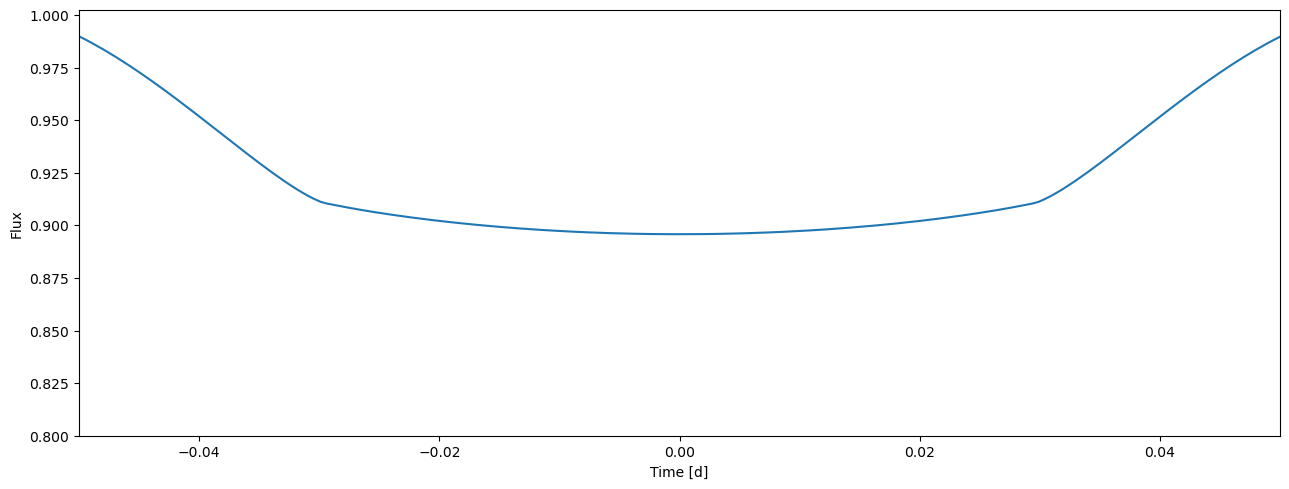

In [13]:
# Assuming new_dimensions, x_coords, y_coords, and brightness_values are predefined
image_size = new_dimensions
#num_images = 200
output_folder = "generated_images"
star_positions = np.column_stack((x_coords, y_coords))
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Generate fixed gamma and alpha values
gamma_values = np.random.uniform(3, 7, len(star_positions))
alpha_values = np.random.uniform(2.5, 4.5, len(star_positions))

# Preselect stars for transit
top_5_stars_idx = np.argsort(gamma_values)[-5:]

# Precompute the transit model
#flux = generate_transit_model(num_images)
time = linspace(-0.05, 0.05, num_images)
tm = RoadRunnerModel('nonlinear')
tm.set_data(time)
plot_lc(time, generated_flux);

In [ ]:


# User input for noise
add_noise = input("Would you like to apply random noise to the stars? (yes/no): ").lower()

small_scale = input("Would you like to add small scale observations? (yes/no): ").lower()

# Generate fixed brightness values
if add_noise == 'yes':
        fixed_brightness_values = np.array([brightness + np.random.choice([1, -1]) * np.random.uniform(0, 1/50) * brightness for brightness in brightness_values])
        gamma_values += np.random.normal(0, 0.1, len(star_positions))  # Adding noise to gamma_values
        alpha_values += np.random.normal(0, 0.05, len(star_positions))  # Adding noise to alpha_values
else:
        fixed_brightness_values = np.random.uniform(30000, 60000, len(star_positions))



total_time_seconds = 3 * 3600  # 3 hours in seconds
time_diff_seconds = total_time_seconds / num_images
start_time = datetime.now()

# ... (remaining code for generating gamma_values, alpha_values, etc.)

# Generate images
print("Generating images...")
transit_star_positions = []
for i in tqdm(range(num_images)):
    star_im = generate_fixed_stars(image_size, star_positions, fixed_brightness_values, gamma_values, alpha_values, generated_flux, i, add_noise, top_5_stars_idx)
    
    # Calculate the observation time for this image
    obs_time = start_time + timedelta(seconds=i * time_diff_seconds)
    
    filename = os.path.join(output_folder, f"image_{i}.fits")
    save_image_to_fits(star_im, filename, obs_time)

# Highlight transit stars and print their coordinates
# Create a plot for the star image
plt.imshow(star_im, cmap='gray')
plt.title('Star Field with Transits Highlighted')

# Overlay red circles on stars with transits
for idx in top_5_stars_idx:
    x, y = star_positions[idx]
    transit_star_positions.append((x, y))
    plt.scatter(y, x, s=200, facecolors='none', edgecolors='r')

plt.show()
print("Transit Star Coordinates:", transit_star_positions)


Would you like to apply random noise to the stars? (yes/no):  yes


## Explanation of Code for Simulated Star Field and Light Curve Generation

### Overview

The code aims to generate a series of simulated star field images with the possibility of including star transits, which could represent exoplanets passing in front of their host stars. The generated images are saved in the FITS file format.

### Libraries Used

- **matplotlib**: For data visualization
- **NumPy**: For numerical operations
- **astropy**: To handle FITS files and data tables
- **datetime, timedelta**: For date and time manipulation
- **tqdm**: For progress bars during image generation

### Key Functions

#### `generate_fixed_stars()`

- Takes parameters like image size, star positions, brightness values, gamma and alpha for the Moffat profile, and others.
- Uses the Moffat 2D model to generate the star profiles.
- Returns a 2D NumPy array representing the star field image.

#### `save_image_to_fits()`

- Saves a given 2D NumPy array to a FITS file.
- Adds an observation time to the FITS header.

#### `generate_transit_model()` and `generate_transit_model_2D()`

- Create a series of flux multipliers to simulate the dimming effect of a star during a transit event.

### Code Workflow

1. **User Input for Noise**: The user decides whether to add random noise to the images.
2. **Preparation for Transit**: Preselects a few stars where the transit will be simulated.
3. **Setting Time for Observations**: The code sets the start time and calculates the time difference between subsequent images.
4. **Image Generation**: Loops through generating the star field images and saving them to FITS files.
5. **Light Curve Generation**: The flux of the chosen exoplanet host star is measured across all images to produce a light curve.

### How to Run

Simply run the entire Python script. It will generate FITS files for each simulated image and can also produce a light curve if that part of the code is included.



100%|██████████| 200/200 [00:00<00:00, 435.15it/s]


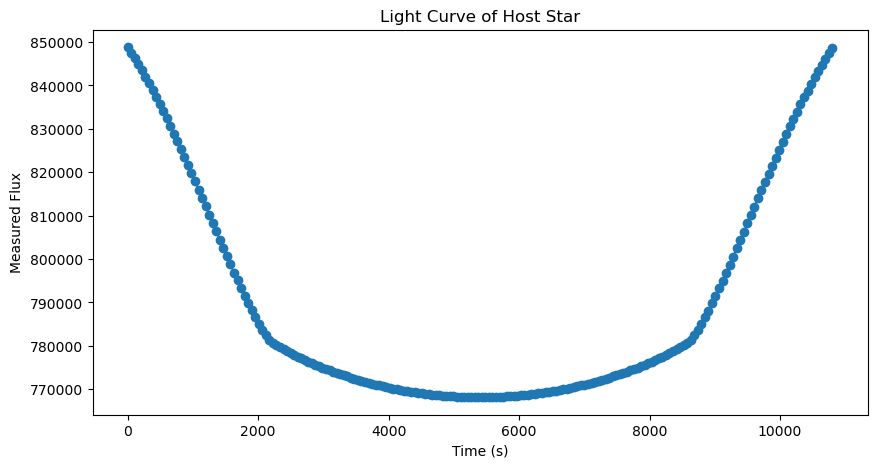

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list to store the measured flux for each image
measured_fluxes = []

# The aperture size to use for summing up the star's flux
aperture_size = 4

# Choose one of the top 5 stars as the exoplanet host star
# You may choose any other index as appropriate
host_star_index = top_5_stars_idx[0]  
host_star_x, host_star_y = star_positions[host_star_index]

# Loop over each generated image to measure the star's flux
for i in tqdm(range(num_images)):
    filename = os.path.join(output_folder, f"image_{i}.fits")
    with fits.open(filename) as hdulist:
        image_data = hdulist[0].data
    
    # Define the aperture for flux measurement
    x_lower = max(int(host_star_x) - aperture_size, 0)
    x_upper = min(int(host_star_x) + aperture_size, image_size[0])
    y_lower = max(int(host_star_y) - aperture_size, 0)
    y_upper = min(int(host_star_y) + aperture_size, image_size[1])
    
    # Sum the pixel values inside the aperture to get the flux
    flux = np.sum(image_data[x_lower:x_upper, y_lower:y_upper])
    measured_fluxes.append(flux)

# Generate timestamps for plotting the light curve
timestamps = np.linspace(0, total_time_seconds, num_images)

# Plot the light curve
plt.figure(figsize=(10, 5))
plt.plot(timestamps, measured_fluxes, marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Measured Flux")
plt.title("Light Curve of Host Star")
plt.show()

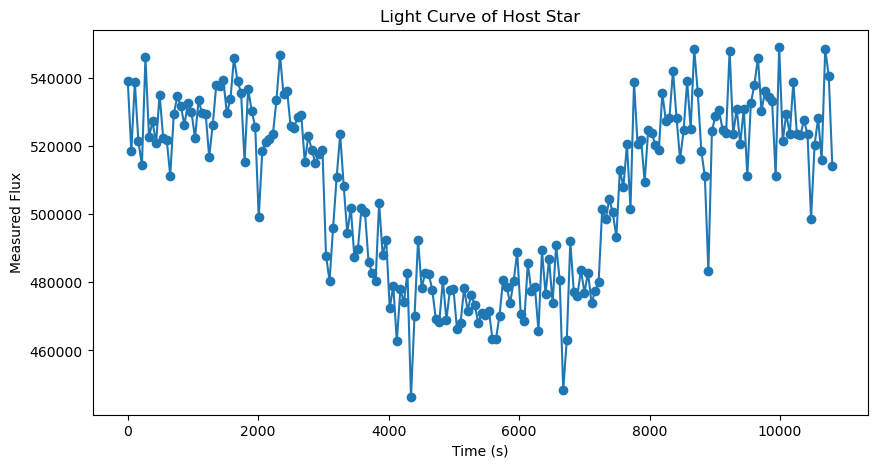

[0.00037963 0.00039815 0.00041667 0.00043519 0.0004537 ]
[0.01473086 0.02004831 0.01959116 0.01253171 0.00520759]


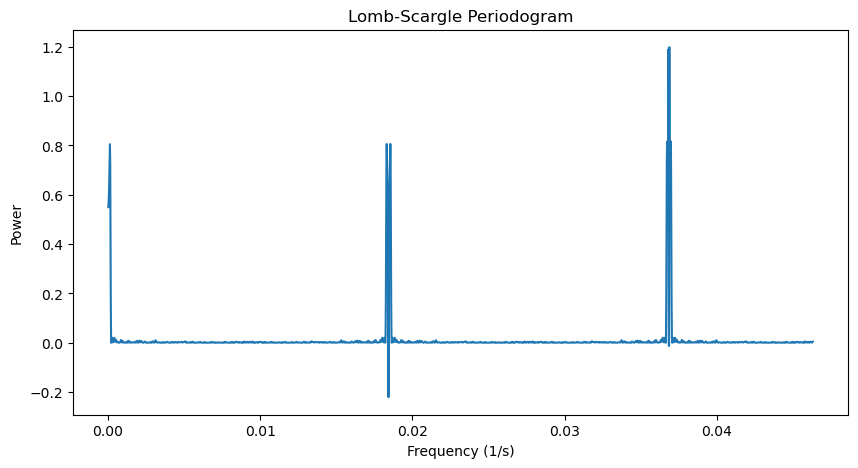

Largest power value between 0 and 0.1 frequency: 0.8050491972617775


In [13]:
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(timestamps, measured_fluxes, marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Measured Flux")
plt.title("Light Curve of Host Star")
plt.show()

median_flux = np.median(measured_fluxes)
# Normalize the flux

flux = np.array(measured_fluxes)

measured_fluxes
#flux = (flux - np.mean(flux)) / np.std(flux)

norm_flux = measured_fluxes / median_flux
# Compute the Lomb-Scargle periodogram of the light curve
frequency, power = LombScargle(timestamps, norm_flux).autopower()

# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(frequency, power)
print(frequency[20:25])
print(power[20:25])
plt.title('Lomb-Scargle Periodogram')
plt.xlabel('Frequency (1/s)')
plt.ylabel('Power')
plt.show()


mask = (frequency >= 0) & (frequency <= 0.01)


max_power_within_range = np.max(power[mask])

period = 1 / max_power_within_range


print(f"Largest power value between 0 and 0.1 frequency: {max_power_within_range}")


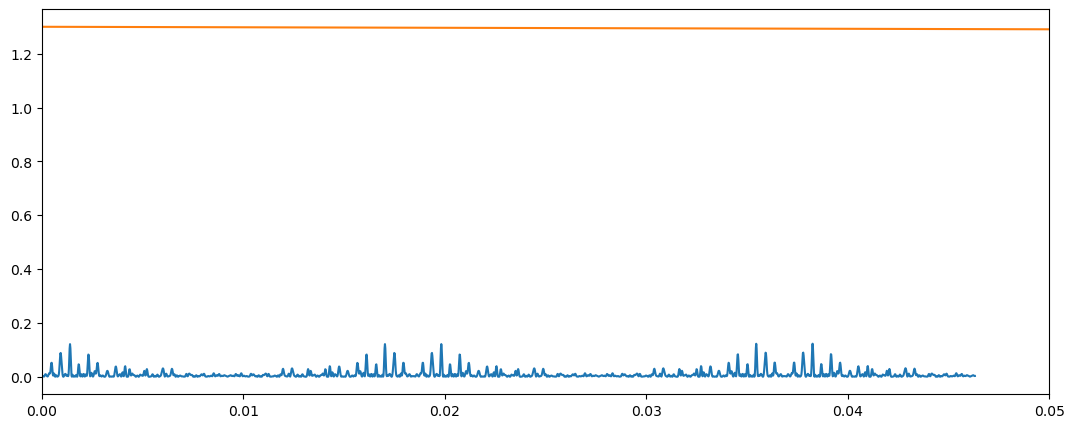

In [144]:
import numpy as np

class Planet_Transit:
    def __init__(self, period, contrast_ratio, transit_duration, first_transit_time):
        """
        This class contains the bare minimum parameters necessary to describe a planet
        transiting in front of a star
        """
        self.P = period         # the orbital period
        self.k = contrast_ratio # the square of the ratio of the effective 
                                # radii of the planet and of the star
        self.tau = transit_duration      # the time it takes to transit
        self.t0 = first_transit_time    # the time at which the planet is at
                                        # the middle point of a transit.
                                        # It is needed to fix a reference time
        
    def is_in_transit(self, t):
        """
        return whether the planet is transiting the star at time t
        """
        return np.mod(t - (self.t0-self.tau/2), self.P) < self.tau

def light_curve(t_start, t_end, dt, planet_transits):
    Dt = t_end-t_start
    t = np.linspace(t_start, t_end, int(Dt/dt))
    
    lc = np.ones(t.shape) # the light curve
    
    for p in planet_transits:
        lc = lc - p.k * p.is_in_transit(t)
    return t, lc

import matplotlib.pyplot as plt

P1 = 8
P2 = 13
planet_transits =[
 Planet_Transit(P1, 0.01, 0.1, 0.3),
 Planet_Transit(P2, 0.005, 0.06, 0.5)
 ]

t_start = 0
t_end = 1
dt = 0.001


from scipy.fft import fft

# The array of frequencies
freq = np.linspace(0, 1/dt, len(t))
# The fourier transform. Notice that I subtract 1 from lc, in order to
# suppress the zero frequency mode.
transform =  np.abs(fft(lc-1))
plt.plot(frequency, power)


# The array of frequencies
freq = np.linspace(0, 1/dt, len(t))
# The fourier transform. Notice that I subtract 1 from lc, in order to
# suppress the zero frequency mode.
transform =  np.abs(fft(lc-1))
plt.plot(freq, transform)
plt.xlim(0,.05)
plt.axvline(1/P1, color="red")
plt.axvline(1/P2, color="red")
plt.show()

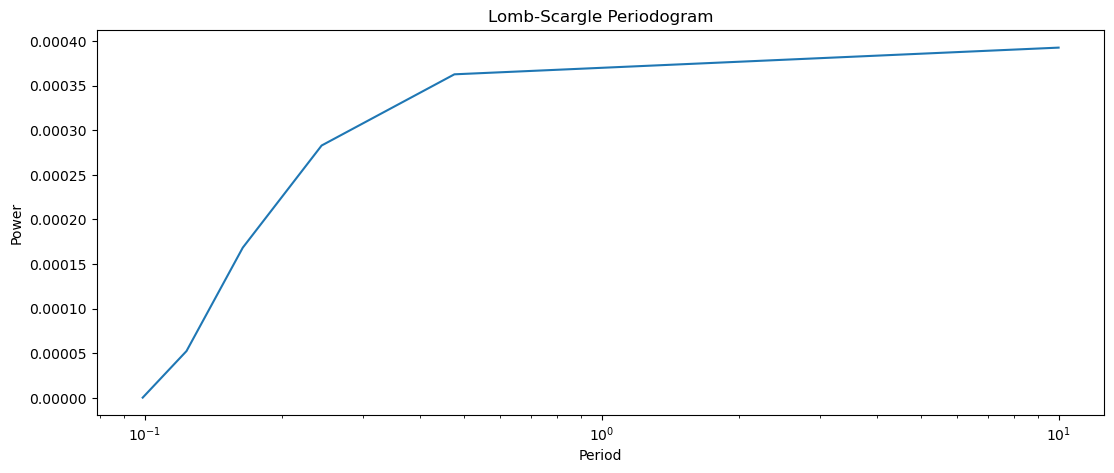

Best period:  10.0


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

# Assuming time and flux are numpy arrays representing your light curve
# time = np.array([...])
# flux = np.array([...])

# Normalizing the flux
flux_normalized = (flux - np.mean(flux)) / np.std(flux)

# Compute the Lomb-Scargle Periodogram
frequency, power = LombScargle(time, flux_normalized).autopower(minimum_frequency=0.1, maximum_frequency=10)

# Find the frequency of the peak
best_freq = frequency[np.argmax(power)]

# Now, convert the frequency to a period
best_period = 1 / best_freq

# Plotting the Periodogram
plt.plot(1 / frequency, power)
plt.title('Lomb-Scargle Periodogram')
plt.xlabel('Period')
plt.ylabel('Power')
plt.xscale('log')
plt.show()

print("Best period: ", best_period)